In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def vis_model(model, show_shapes=False, show_layer_names=True, rankdir='TB'):
    return SVG(
        model_to_dot(
            model,
            show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir
        ).create(prog='dot', format='svg')
    )

Using TensorFlow backend.


In [3]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from kerashistoryplot.callbacks import PlotHistory

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [167]:
def make_bishop_data(num=1000, sort=True):
    y = np.linspace(0, 1, num=num)
    x = y + 0.3 * np.sin(2 * np.pi * y) + 0.2 * np.random.rand(num) - 0.1
    if sort:
        order = x.argsort()
        x, y = x[order], y[order]
    return x, y
    

X_train, y_train = make_bishop_data(num=10000)
X_test = np.linspace(0, 1, num=100)

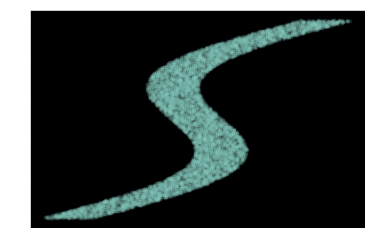

In [168]:
plt.plot(X_train, y_train, '.', alpha=0.1)

In [169]:
import deepquantiles

# Multi-Quantile Regression

In [318]:
regressor = deepquantiles.MultiQuantileRegressor(
    shared_units=(32, 32),
    quantile_units=(32, 32),
    quantiles=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99],
    lr=0.01,
    epochs=10,
    batch_size=1000
)

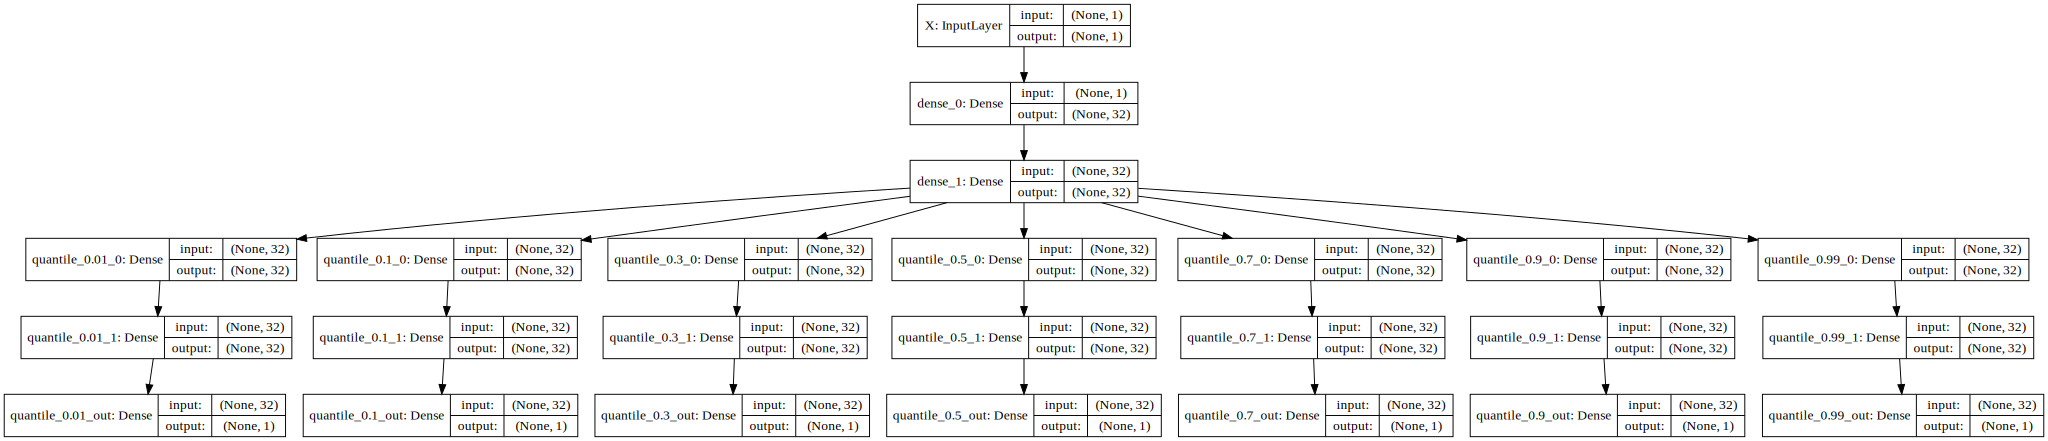

In [319]:
vis_model(regressor.model, show_shapes=True)

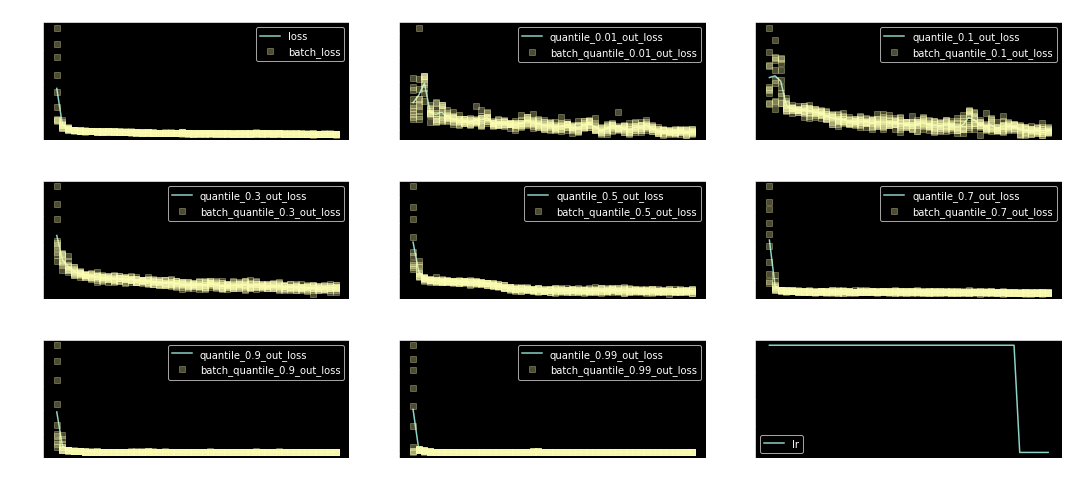

CPU times: user 2min 35s, sys: 16.1 s, total: 2min 51s
Wall time: 1min 27s


In [320]:
%%time
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20, min_delta=0.01),
    EarlyStopping(monitor='loss', patience=30),
    PlotHistory(batches=True, n_cols=3, figsize=(15, 7))
]

regressor.fit(X_train, y_train, epochs=50, batch_size=1000, verbose=1, callbacks=callbacks, shuffle=True)

In [321]:
q_preds = regressor.predict(X_test)

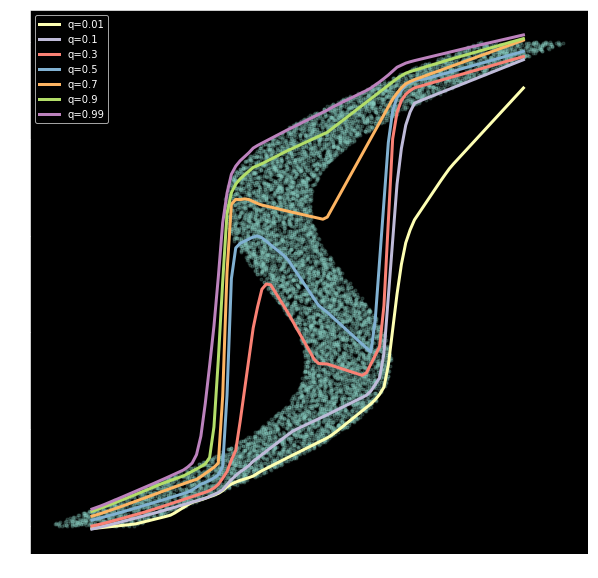

In [322]:
plt.figure(figsize=(10, 10))
plt.plot(X_train, y_train, '.', alpha=0.2)
for q, q_pred in zip(regressor.quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'q={q}')
plt.legend()

(0, 1)

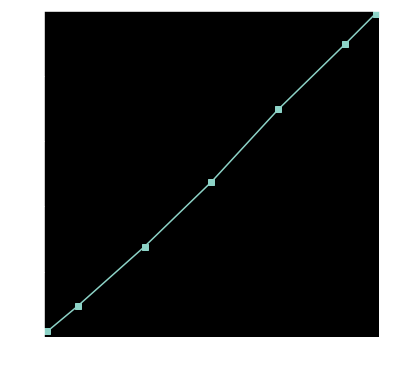

In [323]:
q_preds = regressor.predict(X_train)
calibrations = [np.mean(y_train < q_pred.ravel()) for q, q_pred in zip(regressor.quantiles, q_preds)]

plt.figure(figsize=(6, 6))
plt.plot(regressor.quantiles, calibrations, 's-')
plt.xlabel('quantile (predicted)')
plt.ylabel('fraction of data')
plt.xlim([0, 1])
plt.ylim([0, 1])

## Regress on Quantile `q`

In [324]:
regressor = deepquantiles.CDFRegressor(
    hidden_units=(32, 32, 64, 64,),
    lr=0.01,
    activation='relu'
)

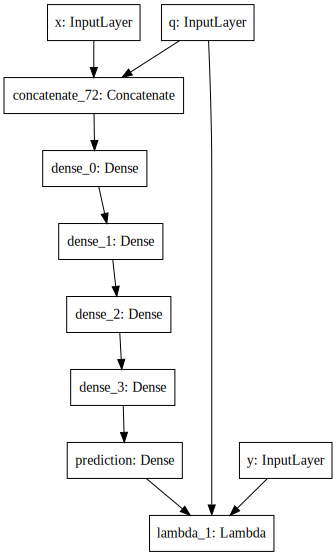

In [325]:
vis_model(regressor.model['loss'])

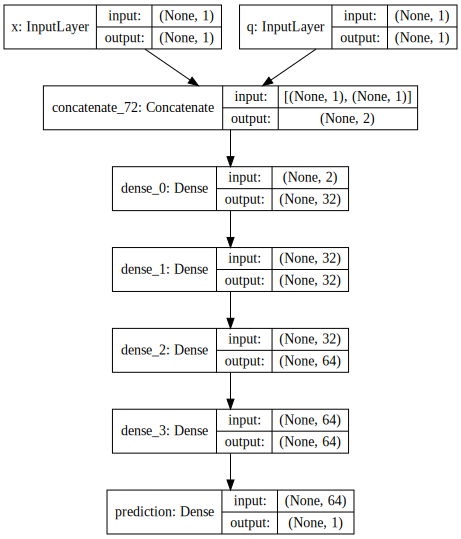

In [326]:
vis_model(regressor.model['quantile'], show_shapes=True)

In [327]:
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20, min_delta=0.01),
    EarlyStopping(monitor='loss', patience=30),
    PlotHistory(batches=True, n_cols=3, figsize=(15, 7))
]

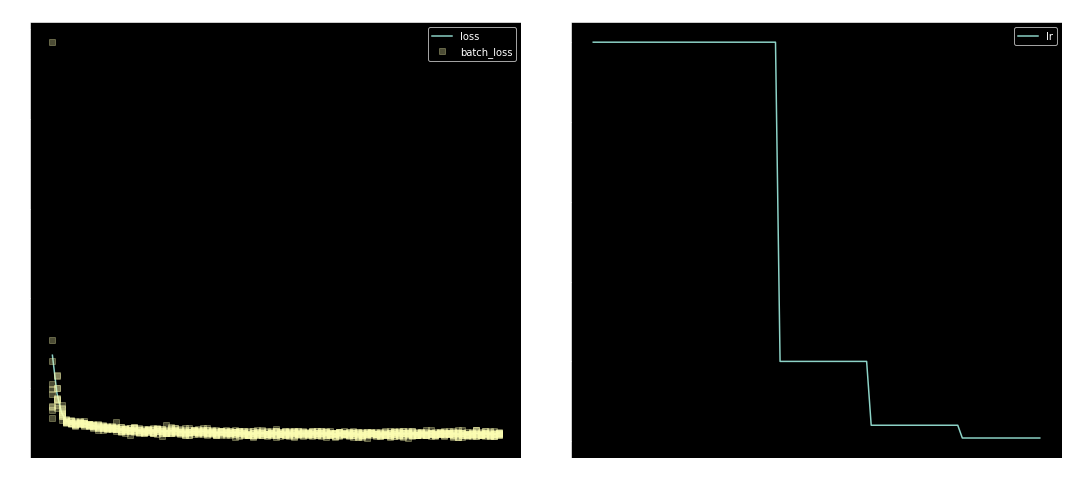

CPU times: user 1min 58s, sys: 17.2 s, total: 2min 15s
Wall time: 1min 2s


In [328]:
%%time
regressor.fit(X_train, y_train, epochs=100, batch_size=1000, verbose=1, callbacks=callbacks,
              q_mode='point', shuffle=True, shuffle_points=True)

In [329]:
quantiles = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
q_preds = []
for q in quantiles:
    q_test = 0 * X_test + q
    q_pred = regressor.predict(X_test, q_test)
    q_preds.append(q_pred)

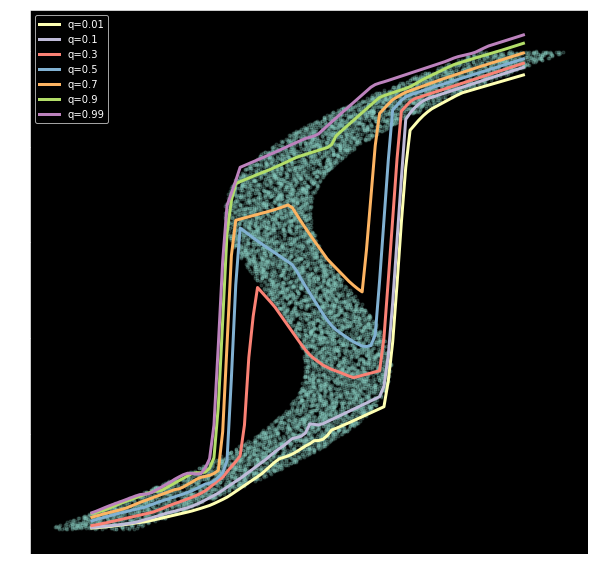

In [330]:
plt.figure(figsize=(10, 10))
plt.plot(X_train, y_train, '.', alpha=0.2)
for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'q={q}')
plt.legend()